In [ ]:
# Step 1: Unzip the dataset
!unzip -q "/content/Dataset_aug.zip" -d .

In [ ]:
import os, cv2
import numpy as np
import tensorflow as tf
from glob import glob
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, Conv2D, concatenate, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [ ]:
class ImageMaskGenerator(Sequence):
    def __init__(self, image_paths, mask_paths, batch_size=8, img_size=128):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.batch_size = batch_size
        self.img_size = img_size

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, idx):
        batch_imgs = self.image_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_masks = self.mask_paths[idx * self.batch_size:(idx + 1) * self.batch_size]

        X, y = [], []
        for img_path, mask_path in zip(batch_imgs, batch_masks):
            img = cv2.imread(img_path)
            img = cv2.resize(img, (self.img_size, self.img_size))
            img = img / 255.0

            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, (self.img_size, self.img_size))
            mask = np.expand_dims(mask / 255.0, axis=-1)

            X.append(img)
            y.append(mask)

        return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

In [ ]:
# Collect paths
input_images = sorted(glob("input/*.png"))
output_masks = sorted(glob("Output/*.png"))

# First split: 70% train, 30% temp (val + test)
train_imgs, temp_imgs, train_masks, temp_masks = train_test_split(
    input_images, output_masks, test_size=0.3, random_state=42
)

# Second split: 50% val, 50% test from the temp set → 15% val, 15% test
val_imgs, test_imgs, val_masks, test_masks = train_test_split(
    temp_imgs, temp_masks, test_size=0.5, random_state=42
)

In [ ]:
# Instantiate generators
train_gen = ImageMaskGenerator(train_imgs, train_masks, batch_size=8, img_size=128)
val_gen = ImageMaskGenerator(val_imgs, val_masks, batch_size=8, img_size=128)
test_gen = ImageMaskGenerator(test_imgs, test_masks, batch_size=8, img_size=128)

In [ ]:
def unet_mobilenet(input_shape=(128, 128, 3)):
    base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')

    # Encoder layers for skip connections
    skips = [
        base_model.get_layer('block_1_expand_relu').output,   # 64x64
        base_model.get_layer('block_3_expand_relu').output,   # 32x32
        base_model.get_layer('block_6_expand_relu').output,   # 16x16
        base_model.get_layer('block_13_expand_relu').output   # 8x8
    ]
    bridge = base_model.get_layer('block_16_project').output  # 4x4

    x = bridge
    for skip in reversed(skips):
        x = UpSampling2D()(x)
        x = concatenate([x, skip])
        x = Conv2D(128, 3, padding='same', activation='relu')(x)

    x = UpSampling2D(size=(2, 2))(x)  # final upsample to 128x128
    x = Conv2D(64, 3, padding='same', activation='relu')(x)
    output = Conv2D(1, 1, activation='sigmoid')(x)

    return Model(inputs=base_model.input, outputs=output)

model = unet_mobilenet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 3,888,577 (14.83 MB)

 Trainable params: 3,857,665 (14.72 MB)

 Non-trainable params: 30,912 (120.75 KB)

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3),
    ModelCheckpoint("light_model.h5", save_best_only=True)
]

model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=callbacks
)

Epoch 1/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9739 - loss: 0.0470

189/189 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step - accuracy: 0.9739 - loss: 0.0470 - val_accuracy: 0.9777 - val_loss: 0.0975 - learning_rate: 1.0000e-04
Epoch 2/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9763 - loss: 0.0400

189/189 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.9763 - loss: 0.0400 - val_accuracy: 0.9768 - val_loss: 0.0839 - learning_rate: 1.0000e-04
Epoch 3/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.9754 - loss: 0.0382 - val_accuracy: 0.9777 - val_loss: 0.0891 - learning_rate: 1.0000e-04
Epoch 4/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.9760 - loss: 0.0349 - val_accuracy: 0.9777 - val_loss: 0.0843 - learning_rate: 1.0000e-04
Epoch 5/30
188/189 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9757 - loss: 0.0330

189/189 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - accuracy: 0.9757 - loss: 0.0330 - val_accuracy: 0.9776 - val_loss: 0.0784 - learning_rate: 1.0000e-04
Epoch 6/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9754 - loss: 0.0315

189/189 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - accuracy: 0.9754 - loss: 0.0315 - val_accuracy: 0.9777 - val_loss: 0.0759 - learning_rate: 1.0000e-04
Epoch 7/30
188/189 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9765 - loss: 0.0291

189/189 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.9765 - loss: 0.0291 - val_accuracy: 0.9762 - val_loss: 0.0575 - learning_rate: 1.0000e-04
Epoch 8/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.9768 - loss: 0.0269 - val_accuracy: 0.9764 - val_loss: 0.0605 - learning_rate: 1.0000e-04
Epoch 9/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9762 - loss: 0.0254

189/189 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - accuracy: 0.9762 - loss: 0.0254 - val_accuracy: 0.9757 - val_loss: 0.0570 - learning_rate: 1.0000e-04
Epoch 10/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.9761 - loss: 0.0251 - val_accuracy: 0.9768 - val_loss: 0.0595 - learning_rate: 1.0000e-04
Epoch 11/30
188/189 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9776 - loss: 0.0225

189/189 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - accuracy: 0.9776 - loss: 0.0225 - val_accuracy: 0.9745 - val_loss: 0.0528 - learning_rate: 1.0000e-04
Epoch 12/30
188/189 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9782 - loss: 0.0220

189/189 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - accuracy: 0.9782 - loss: 0.0220 - val_accuracy: 0.9755 - val_loss: 0.0497 - learning_rate: 1.0000e-04
Epoch 13/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.9760 - loss: 0.0223 - val_accuracy: 0.9774 - val_loss: 0.0641 - learning_rate: 1.0000e-04
Epoch 14/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 0.9773 - loss: 0.0204 - val_accuracy: 0.9759 - val_loss: 0.0508 - learning_rate: 1.0000e-04
Epoch 15/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.9786 - loss: 0.0186 - val_accuracy: 0.9772 - val_loss: 0.0510 - learning_rate: 1.0000e-04
Epoch 16/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9773 - loss: 0.0191

189/189 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - accuracy: 0.9773 - loss: 0.0191 - val_accuracy: 0.9765 - val_loss: 0.0473 - learning_rate: 1.0000e-05
Epoch 17/30
188/189 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9779 - loss: 0.0179

189/189 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - accuracy: 0.9779 - loss: 0.0179 - val_accuracy: 0.9768 - val_loss: 0.0461 - learning_rate: 1.0000e-05
Epoch 18/30
188/189 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9765 - loss: 0.0183

189/189 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - accuracy: 0.9765 - loss: 0.0183 - val_accuracy: 0.9770 - val_loss: 0.0454 - learning_rate: 1.0000e-05
Epoch 19/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9773 - loss: 0.0182

189/189 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - accuracy: 0.9773 - loss: 0.0182 - val_accuracy: 0.9769 - val_loss: 0.0432 - learning_rate: 1.0000e-05
Epoch 20/30
188/189 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9788 - loss: 0.0167

189/189 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.9788 - loss: 0.0167 - val_accuracy: 0.9768 - val_loss: 0.0412 - learning_rate: 1.0000e-05
Epoch 21/30
188/189 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9794 - loss: 0.0164

189/189 ━━━━━━━━━━━━━━━━━━━━ 21s 56ms/step - accuracy: 0.9794 - loss: 0.0165 - val_accuracy: 0.9772 - val_loss: 0.0402 - learning_rate: 1.0000e-05
Epoch 22/30
188/189 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9763 - loss: 0.0181

189/189 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - accuracy: 0.9764 - loss: 0.0181 - val_accuracy: 0.9771 - val_loss: 0.0385 - learning_rate: 1.0000e-05
Epoch 23/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9792 - loss: 0.0159

189/189 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - accuracy: 0.9792 - loss: 0.0159 - val_accuracy: 0.9775 - val_loss: 0.0376 - learning_rate: 1.0000e-05
Epoch 24/30
188/189 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9780 - loss: 0.0167

189/189 ━━━━━━━━━━━━━━━━━━━━ 12s 63ms/step - accuracy: 0.9780 - loss: 0.0167 - val_accuracy: 0.9776 - val_loss: 0.0366 - learning_rate: 1.0000e-05
Epoch 25/30
188/189 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9775 - loss: 0.0168

189/189 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - accuracy: 0.9775 - loss: 0.0168 - val_accuracy: 0.9777 - val_loss: 0.0353 - learning_rate: 1.0000e-05
Epoch 26/30
188/189 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9775 - loss: 0.0166

189/189 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - accuracy: 0.9775 - loss: 0.0166 - val_accuracy: 0.9781 - val_loss: 0.0353 - learning_rate: 1.0000e-05
Epoch 27/30
188/189 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9779 - loss: 0.0163

189/189 ━━━━━━━━━━━━━━━━━━━━ 21s 56ms/step - accuracy: 0.9779 - loss: 0.0163 - val_accuracy: 0.9781 - val_loss: 0.0337 - learning_rate: 1.0000e-05
Epoch 28/30
188/189 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9774 - loss: 0.0166

189/189 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - accuracy: 0.9774 - loss: 0.0166 - val_accuracy: 0.9781 - val_loss: 0.0331 - learning_rate: 1.0000e-05
Epoch 29/30
188/189 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9785 - loss: 0.0156

189/189 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - accuracy: 0.9785 - loss: 0.0156 - val_accuracy: 0.9782 - val_loss: 0.0327 - learning_rate: 1.0000e-05
Epoch 30/30
188/189 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9776 - loss: 0.0163

189/189 ━━━━━━━━━━━━━━━━━━━━ 21s 62ms/step - accuracy: 0.9776 - loss: 0.0163 - val_accuracy: 0.9783 - val_loss: 0.0326 - learning_rate: 1.0000e-05


In [ ]:
import numpy as np

# Predict on test data in batches
y_true_all = []
y_pred_all = []

for i in range(len(test_gen)):
    X_batch, y_batch = test_gen[i]
    y_pred_batch = model.predict(X_batch)

    y_true_all.append(y_batch)
    y_pred_all.append(y_pred_batch)

# Concatenate all batches
y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)

# Threshold predictions
y_pred_thresh = (y_pred_all > 0.5).astype(np.uint8)
y_true_thresh = (y_true_all > 0.5).astype(np.uint8)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━

In [ ]:
def dice_coefficient(y_true, y_pred):
    smooth = 1e-7
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def iou_score(y_true, y_pred):
    smooth = 1e-7
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    union = np.sum(y_true_f) + np.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)
dice = dice_coefficient(y_true_thresh, y_pred_thresh)
iou = iou_score(y_true_thresh, y_pred_thresh)
acc = np.mean((y_true_thresh == y_pred_thresh).astype(np.float32))

print(f"✅ Test Accuracy: {acc:.4f}")
print(f"🎯 Test Dice Coefficient: {dice:.4f}")
print(f"📊 Test IoU Score: {iou:.4f}")

✅ Test Accuracy: 0.9908
🎯 Test Dice Coefficient: 0.6754
📊 Test IoU Score: 0.5098


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


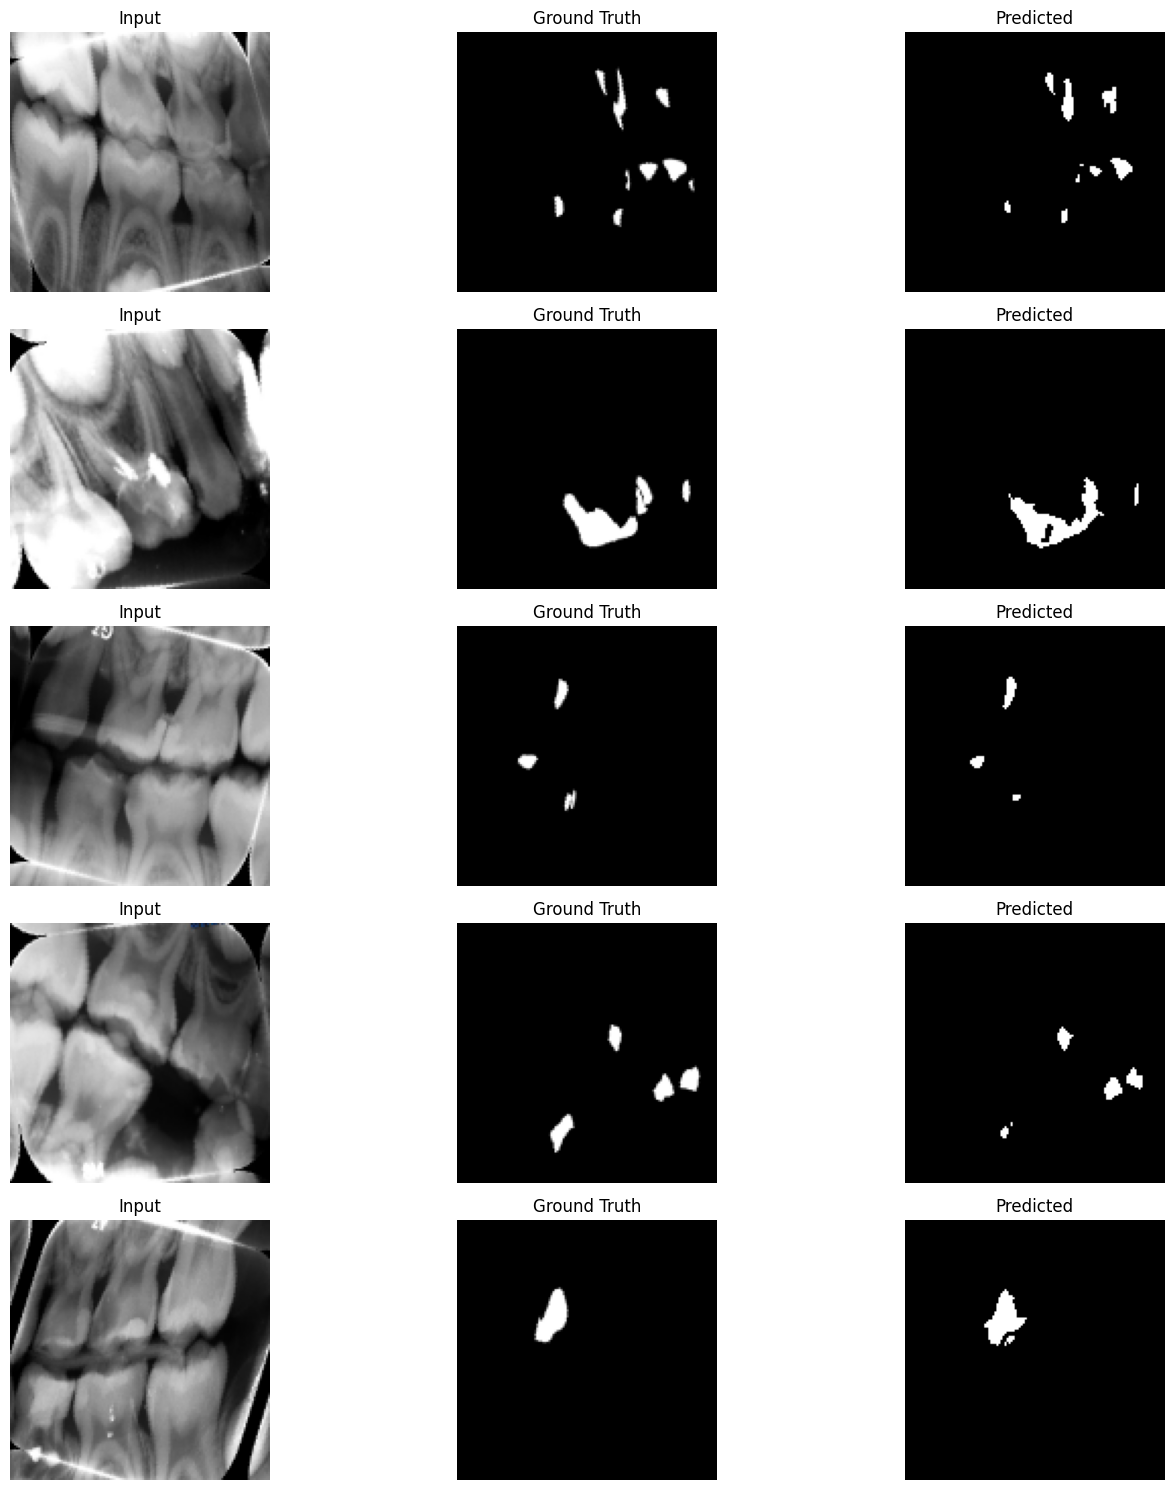

In [ ]:
import matplotlib.pyplot as plt

def show_sample_predictions(generator, model, num_samples=5):
    X_batch, y_batch = generator[0]  # Get first batch
    y_pred_batch = model.predict(X_batch)
    y_pred_thresh = (y_pred_batch > 0.5).astype(np.uint8)

    plt.figure(figsize=(15, num_samples * 3))
    for i in range(min(num_samples, len(X_batch))):
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(X_batch[i])
        plt.title("Input")
        plt.axis('off')

        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(y_batch[i].squeeze(), cmap='gray')
        plt.title("Ground Truth")
        plt.axis('off')

        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(y_pred_thresh[i].squeeze(), cmap='gray')
        plt.title("Predicted")
        plt.axis('off')

    plt.tight_layout()
    plt.show()
show_sample_predictions(test_gen, model, num_samples=5)

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    if not history or not hasattr(history, 'history'):
        print("Invalid history object.")
        return

    acc = history.history.get('accuracy', [])
    val_acc = history.history.get('val_accuracy', [])
    loss = history.history.get('loss', [])
    val_loss = history.history.get('val_loss', [])

    plt.figure(figsize=(12, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Train Accuracy', marker='o')
    plt.plot(val_acc, label='Val Accuracy', marker='o')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Train Loss', marker='o')
    plt.plot(val_loss, label='Val Loss', marker='o')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━

<Figure size 500x500 with 0 Axes>

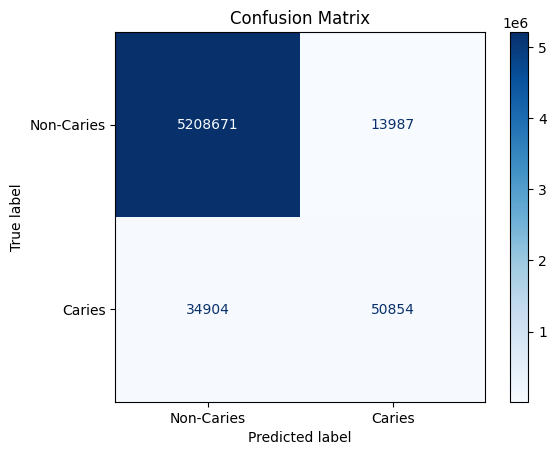

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Collect predictions and ground truths from test_gen
y_true_all = []
y_pred_all = []

for i in range(len(test_gen)):
    X_batch, y_batch = test_gen[i]
    y_pred_batch = model.predict(X_batch)

    y_true_all.append(y_batch)
    y_pred_all.append(y_pred_batch)

# Step 2: Flatten arrays for confusion matrix input
y_true_flat = np.concatenate(y_true_all, axis=0).flatten()
y_pred_flat = np.concatenate(y_pred_all, axis=0).flatten()

# Step 3: Binarize
y_true_flat = (y_true_flat > 0.5).astype(np.uint8)
y_pred_flat = (y_pred_flat > 0.5).astype(np.uint8)

# Step 4: Compute confusion matrix
cm = confusion_matrix(y_true_flat, y_pred_flat)

# Step 5: Display it
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Caries", "Caries"])
plt.figure(figsize=(5, 5))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

<Figure size 500x500 with 0 Axes>

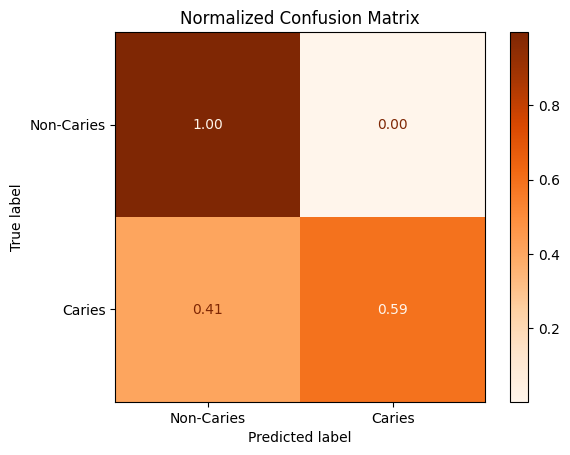

In [ ]:
# Compute normalized confusion matrix (row-wise normalization)
cm_normalized = confusion_matrix(y_true_flat, y_pred_flat, normalize='true')

# Display normalized confusion matrix
disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=["Non-Caries", "Caries"])
plt.figure(figsize=(5, 5))
disp_norm.plot(cmap=plt.cm.Oranges, values_format='.2f')
plt.title("Normalized Confusion Matrix")
plt.grid(False)
plt.show()


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Generate classification report
report = classification_report(
    y_true_flat, y_pred_flat,
    target_names=["Non-Caries", "Caries"],
    digits=4
)

print("📋 Classification Report:\n")
print(report)

📋 Classification Report:

              precision    recall  f1-score   support

  Non-Caries     0.9933    0.9973    0.9953   5222658
      Caries     0.7843    0.5930    0.6754     85758

    accuracy                         0.9908   5308416
   macro avg     0.8888    0.7952    0.8353   5308416
weighted avg     0.9900    0.9908    0.9902   5308416



In [ ]:
import numpy as np

def sensitivity(y_true, y_pred):
    # Sensitivity = TP / (TP + FN)
    TP = np.sum((y_true == 1) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    return TP / (TP + FN + 1e-7)  # add small epsilon to avoid division by zero

def specificity(y_true, y_pred):
    # Specificity = TN / (TN + FP)
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    return TN / (TN + FP + 1e-7)

# Assuming y_true_flat and y_pred_flat are defined and binarized as before:
sens = sensitivity(y_true_flat, y_pred_flat)
spec = specificity(y_true_flat, y_pred_flat)

print(f"🔍 Sensitivity (Recall): {sens:.4f}")
print(f"🔍 Specificity: {spec:.4f}")

🔍 Sensitivity (Recall): 0.5930
🔍 Specificity: 0.9973
